In [2]:
import os
import time

import matplotlib.pyplot as plt
import timm_3d
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
from tqdm import tqdm
import logging
import seaborn as sn

from rsna_dataloader import *
from constants import *

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:277.)


In [3]:
CONFIG = dict(
    n_levels=5,
    num_classes=25,
    num_conditions=5,
    image_interpolation="nearest",
    # backbone="maxvit_rmlp_nano_rw_256",
    backbone="coatnet_rmlp_3_rw_224",
    vol_size=(128, 128, 128),
    loss_weights=CLASS_LOGN_RELATIVE_WEIGHTS_MIRROR,
    num_workers=10,
    gradient_acc_steps=4,
    drop_rate=0.4,
    drop_rate_last=0.,
    drop_path_rate=0.4,
    aug_prob=0.9,
    out_dim=3,
    epochs=60,
    batch_size=5,
    split_rate=0.25,
    split_k=5,
    device=torch.device("cuda") if torch.cuda.is_available() else "cpu",
    seed=2024
)
DATA_BASEPATH = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
TRAINING_DATA = retrieve_coordinate_training_data(DATA_BASEPATH)

In [4]:
import torch.nn as nn
import timm_3d
from spacecutter import *
from spacecutter.losses import *
from spacecutter.models import *
from spacecutter.callbacks import *


class Classifier3dMultihead(nn.Module):
    def __init__(self,
                 backbone="efficientnet_lite0",
                 in_chans=1,
                 out_classes=5,
                 cutpoint_margin=0.15,
                 pretrained=False):
        super(Classifier3dMultihead, self).__init__()
        self.out_classes = out_classes

        self.backbone = timm_3d.create_model(
            backbone,
            features_only=False,
            drop_rate=CONFIG["drop_rate"],
            drop_path_rate=CONFIG["drop_path_rate"],
            pretrained=pretrained,
            in_chans=in_chans,
            global_pool="max",
        )
        if "efficientnet" in backbone:
            head_in_dim = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Sequential(
                nn.LayerNorm(head_in_dim),
                nn.Dropout(CONFIG["drop_rate_last"]),
            )

        elif "vit" in backbone or "coat" in backbone:
            self.backbone.head.drop = nn.Dropout(p=CONFIG["drop_rate_last"])
            head_in_dim = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()

        self.heads = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(head_in_dim, 1),
                LogisticCumulativeLink(CONFIG["out_dim"])
            ) for i in range(out_classes)]
        )

        self.ascension_callback = AscensionCallback(margin=cutpoint_margin)

    def forward(self, x):
        feat = self.backbone(x)
        return torch.swapaxes(torch.stack([head(feat) for head in self.heads]), 0, 1)

    def _ascension_callback(self):
        for head in self.heads:
            self.ascension_callback.clip(head[-1])


In [5]:
import torch

model = Classifier3dMultihead(backbone=CONFIG["backbone"], in_chans=3, out_classes=5).to(device)
model.load_state_dict(torch.load("../models/coatnet_rmlp_3_rw_224_128_vertebrae_tuned_fold_0/coatnet_rmlp_3_rw_224_128_vertebrae_tuned_fold_0_1.pt"))
model.eval()

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3588.)


Classifier3dMultihead(
  (backbone): MaxxVit(
    (stem): Stem(
      (conv1): Conv3d(3, 96, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (norm1): BatchNormAct3d(
        96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (conv2): Conv3d(96, 192, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (stages): Sequential(
      (0): MaxxVitStage(
        (blocks): Sequential(
          (0): MbConvBlock(
            (shortcut): Downsample3d(
              (pool): AvgPool3d(kernel_size=2, stride=2, padding=0)
              (expand): Identity()
            )
            (pre_norm): BatchNormAct3d(
              192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (down): Identity()
            (conv1_1x1): Conv3d(192, 768, kerne

In [6]:
bounds_dataframe = pd.read_csv(os.path.join("../data/lumbar-coordinate-pretraining-dataset/bounding_boxes_3d.csv"))


import numpy as np

conditions = sorted(TRAINING_DATA["condition"].unique())

transform_3d_val = tio.Compose([
    tio.CropOrPad(target_shape=CONFIG["vol_size"]),
    tio.RescaleIntensity((0, 1)),
])

folds = create_vertebra_level_datasets_and_loaders_k_fold(TRAINING_DATA,
                                                          bounds_dataframe,
                                                            transform_3d_train=transform_3d_val,
                                                            transform_3d_val=transform_3d_val,
                                                            base_path=os.path.join(
                                                                DATA_BASEPATH,
                                                                "train_images"),
                                                            vol_size=(128, 128, 128),
                                                            num_workers=0,
                                                            split_k=5,
                                                            batch_size=1,
                                                            use_mirroring_trick=True)

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [7]:
trainloader, valloader, trainset, valset = folds[0]

In [8]:
from torch.cuda.amp import autocast
from tqdm import tqdm

inferred = []
target = []

with torch.no_grad():
    with autocast(dtype=torch.bfloat16):
        for image, label in tqdm(valloader):
            target.append(label.detach())
            inferred.append(model(image.to(device)).cpu().detach())


100%|██████████| 1785/1785 [03:13<00:00,  9.22it/s]


In [9]:
inferred_new = []
target_new = []
for e in inferred:
    for elem in e:
        inferred_new.append(elem.reshape((-1, 5, 3)))
for e in target:
    for elem in e:
        target_new.append([[0 if i != elem_ else 1 for i in range(3)] for elem_ in elem])
        
        
inferred_new[1], target_new[1]

(tensor([[[9.9149e-01, 7.9169e-03, 5.9140e-04],
          [9.8720e-01, 1.1326e-02, 1.4706e-03],
          [9.8830e-01, 1.0716e-02, 9.8574e-04],
          [9.8304e-01, 1.4852e-02, 2.1095e-03],
          [9.9979e-01, 1.9270e-04, 1.5616e-05]]]),
 [[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0]])

In [10]:
inferred_l = [[np.argmax(e_) for e_ in e.detach().cpu()[0]] for e in inferred_new]
target_l = [[np.argmax(e_) for e_ in e] for e in target_new]

In [11]:
len(inferred_l[1]), len(target_l[1])

(5, 5)

In [12]:
conditions

['Left Neural Foraminal Narrowing',
 'Left Subarticular Stenosis',
 'Right Neural Foraminal Narrowing',
 'Right Subarticular Stenosis',
 'Spinal Canal Stenosis']

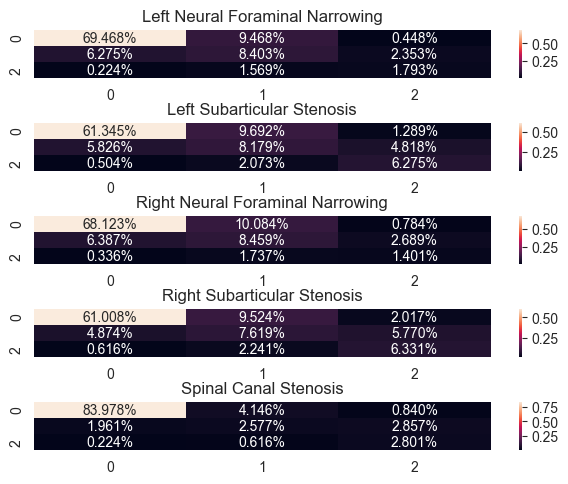

In [13]:
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix
from operator import truediv

precisions = []
recalls = []

fig, ax = plt.subplots(nrows=5, ncols=1, squeeze=False)
fig.tight_layout()
for i in range(5):
    target_ = [e[i] for e in target_l]
    inferred_ = [e[i] for e in inferred_l]
    
    ax[i][0].set_title(conditions[i])
    
    cf_matrix = confusion_matrix(target_, inferred_)
    sn.heatmap(cf_matrix / (np.sum(cf_matrix) + 1e-7), ax=ax[i][0], annot=True, fmt='.3%')

    true_pos = np.diag(cf_matrix)
    prec = list(map(truediv, true_pos, np.sum(cf_matrix, axis=0) + 1e-7))
    rec = list(map(truediv, true_pos, np.sum(cf_matrix, axis=1) + 1e-7))
    
    precisions.append(prec)
    recalls.append(rec)

plt.show()


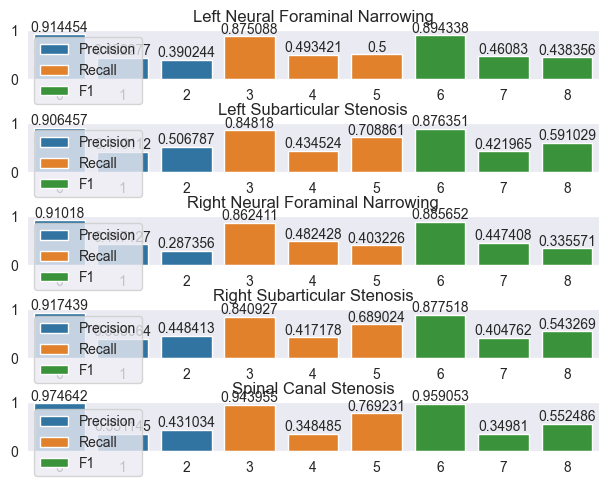

In [14]:
fig, ax = plt.subplots(nrows=5, ncols=1)
fig.tight_layout()

plt.set_loglevel('WARNING')
for i in range(5):
    try:
        val_len = len(precisions[i])
        ax[i].set(ylim=(0, 1))
        
        ax[i].set_title(conditions[i])
        sn.barplot(x=range(val_len), y=precisions[i], ax=ax[i], label='Precision')
        sn.barplot(x=range(val_len, val_len * 2), y=recalls[i], ax=ax[i], label='Recall')
        bar_ax = sn.barplot(x=range(val_len * 2, val_len * 3), y=2 / (1 / (np.array(recalls[i]) + 1e-7) + 1 / (np.array(precisions[i]) + 1e-7)), ax=ax[i], label="F1")
        for i in bar_ax.containers:
           bar_ax.bar_label(i,)
    except:
        pass

plt.show()

In [15]:
import timm_3d
timm_3d.list_models()

['coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_2_rw_384',
 'coatnet_rmlp_3_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224',
 'convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tin